# **Visualization of Interval MixUp**

# Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection
import matplotlib.lines as mlines
from scipy.stats import beta
from typing import Tuple

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

# Create dataset

In [ ]:
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

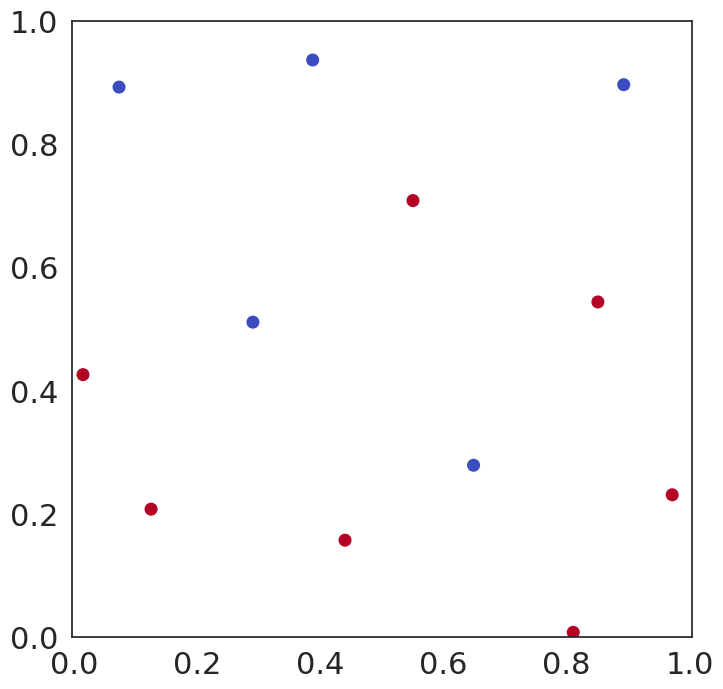

In [ ]:
# Create visualizations
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([-0,1,-0,1])

# Beta distribution

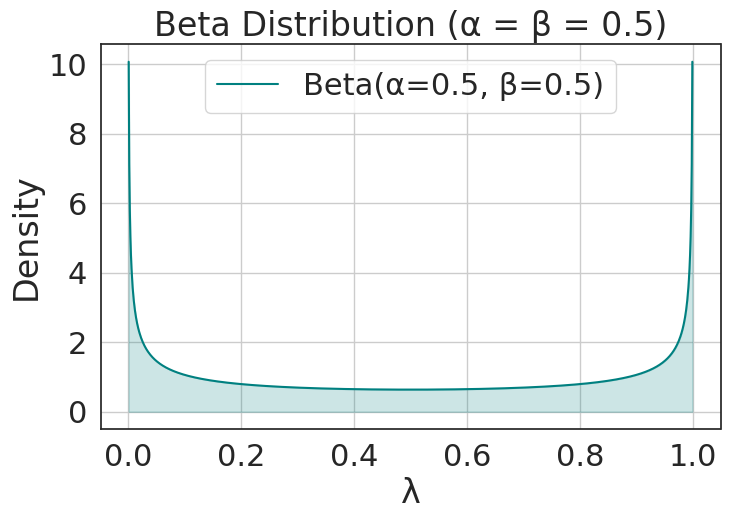

In [ ]:
# Parameters
alpha = 0.5
x_beta = np.linspace(0, 1, 1000)
y_beta = beta.pdf(x_beta, alpha, alpha)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_beta, y_beta, label=f'Beta(α={alpha}, β={alpha})', color='teal')
plt.fill_between(x_beta, y_beta, alpha=0.2, color='teal')
plt.title(f'Beta Distribution (α = β = {alpha})')
plt.xlabel('λ')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

# MixUp

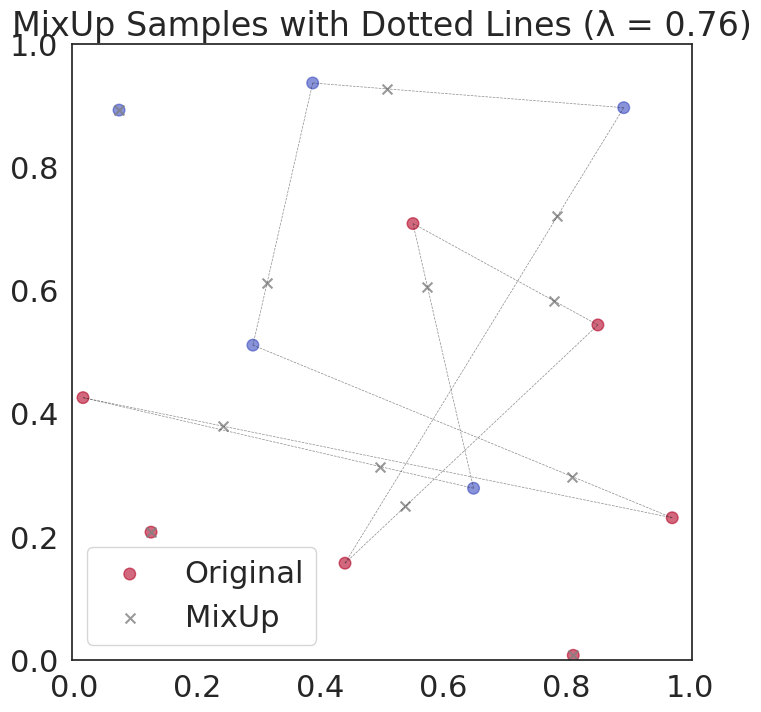

In [ ]:
def mixup_data(x: torch.Tensor, y: torch.Tensor, alpha=1.0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float, int]:
    """Applies mixup augmentation to the input data."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam, index

def mixup_criterion(criterion: nn.Module, pred: torch.Tensor, y_a: torch.Tensor, y_b: torch.Tensor, lam: float) -> torch.Tensor:
    """Computes the mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# Apply MixUp
mixed_x, y_a, y_b, lam, index = mixup_data(X, y, alpha=0.5)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Original samples
ax.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y.numpy(), cmap="coolwarm", s=70, label='Original', alpha=0.6)

# MixUp samples
ax.scatter(mixed_x.numpy()[:, 0], mixed_x.numpy()[:, 1], marker='x', c='gray', s=50, label='MixUp', alpha=0.8)

# Dotted lines from each MixUp sample to the two original samples
for i in range(X.shape[0]):
    x1 = X[i]
    x2 = X[index[i]]
    xm = mixed_x[i]
    ax.plot([x1[0], xm[0]], [x1[1], xm[1]], 'k--', linewidth=0.5, alpha=0.5)
    ax.plot([x2[0], xm[0]], [x2[1], xm[1]], 'k--', linewidth=0.5, alpha=0.5)

ax.axis("equal")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.set_title(f"MixUp Samples with Dotted Lines (λ = {lam:.2f})")
plt.show()

# Create MLP-based interval neural network

In [ ]:
class MLPIntervalNet(nn.Module):
  def __init__(self, in_features: int, out_features: int) -> None:
    super().__init__()

    self.layers = nn.ModuleList([
          nn.Linear(in_features,100),
          nn.ReLU(),
          nn.Linear(100,100),
          nn.ReLU(),
          nn.Linear(100,100),
          nn.ReLU(),
          nn.Linear(100,100),
          nn.ReLU(),
          nn.Linear(100,out_features)
     ])

  def forward(self, mu: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
    mu, eps = mu.T, eps.T
    for layer in self.layers:
        if isinstance(layer, nn.Linear):
            W = layer.weight
            b = layer.bias
            mu = W @ mu + b[:, None]
            eps = torch.abs(W) @ eps
        elif isinstance(layer, nn.ReLU):
            z_l, z_u = mu - eps, mu + eps
            z_l, z_u = F.relu(z_l), F.relu(z_u)
            mu = (z_u + z_l) / 2
            eps = (z_u - z_l) / 2
    mu, eps = mu.T, eps.T
    return mu - eps, mu + eps, mu, eps

In [ ]:
# Function that trains the model
def train_model(X: torch.Tensor, y: torch.Tensor, net: nn.Module, epsilon: float, alpha: float) -> nn.Module:

  N = 2_000
  NN = 1_000

  criterion = nn.CrossEntropyLoss()
  opt = optim.Adam(net.parameters(), lr=1e-3)

  for i in range(N):

      if i < NN:
        eps = (i/(NN-1))*epsilon*torch.ones_like(X)
      else:
        eps = epsilon*torch.ones_like(X)

      kappa = max(1 - 0.00005*i, 0.5)

      mixed_x, y_a, y_b, lam, index = mixup_data(X, y, alpha=alpha)

      # Transform eps
      eps_transformed = abs(2*lam-1.0) * eps
      z_lower, z_upper, prediction, eps_prediction = net(mixed_x, eps_transformed)

      z_lower = prediction - eps_prediction
      z_upper = prediction + eps_prediction
      z = torch.where((nn.functional.one_hot(y_a, prediction.size(-1))).bool(), z_lower, z_upper)

      loss_spec = mixup_criterion(criterion, z, y_a, y_b, lam)
      loss_fit = mixup_criterion(criterion, prediction, y_a, y_b, lam)

      loss = kappa * loss_fit + (1 - kappa) * loss_spec

      # To print only
      z = torch.where((nn.functional.one_hot(y, prediction.size(-1))).bool(), z_lower, z_upper)
      worst_case_error = (z.argmax(dim=1) != y).float().sum().item()

      opt.zero_grad()
      loss.backward()
      opt.step()
      with torch.no_grad():
        if i % 100 == 0:
            print(f"Iter: {i}, loss: {loss.data.item()}")

  return net


# Run experiments!

In [ ]:

def plot_results(X: torch.Tensor, y: torch.Tensor, net: nn.Module, eps: float)-> None:
    with torch.no_grad():
        # 1. Create mesh grid
        xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
        grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
        grid_tensor = torch.tensor(grid, dtype=torch.float32)

        # 2. Get model predictions on the grid
        eps_grid = eps * torch.ones_like(grid_tensor)
        _, _, mu_pred, _ = net(grid_tensor, eps_grid)
        zz = (mu_pred[:, 0] - mu_pred[:, 1]).reshape(100, 100).numpy()

        # 3. Plot decision surface
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.contourf(xx, yy, -zz, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))

        # 4. Plot original training samples (no label for auto legend)
        ax.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y.numpy(), cmap="coolwarm", s=70, edgecolor='k')

        # 5. Plot uncertainty boxes
        eps_tensor = eps * torch.ones_like(X)
        for a, eps_box in zip(X, eps_tensor):
            ax.add_patch(patches.Rectangle(
                (a[0] - eps_box[0], a[1] - eps_box[1]),
                2 * eps_box[0], 2 * eps_box[1],
                fill=False, edgecolor='black', linewidth=0.5
            ))

        # 6. Custom shape-only legend
        legend_handles = [
            mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                          markersize=8, markeredgecolor='k', markerfacecolor='white', label='Training sample')
        ]


In [1]:
eps = 0.08
torch.manual_seed(1)
net = MLPIntervalNet(2,2)

net = train_model(X, y, net, eps, alpha=None)
plot_results(X, y, net, eps=0.07)

In [ ]:

def plot_results_with_mixup(X: torch.Tensor, y: torch.Tensor, net: nn.Module, eps: float, num_mixup_samples: int = 5) -> None:
    with torch.no_grad():
        # 1. Create mesh grid
        xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
        grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
        grid_tensor = torch.tensor(grid, dtype=torch.float32)

        # 2. Get model predictions on the grid
        eps_grid = eps * torch.ones_like(grid_tensor)
        _, _, mu_pred, _ = net(grid_tensor, eps_grid)
        zz = (mu_pred[:, 0] - mu_pred[:, 1]).reshape(100, 100).numpy()

        # 3. Plot decision surface
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.contourf(xx, yy, -zz, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))

        # 4. Plot training samples
        scatter_train = ax.scatter(X[:, 0], X[:, 1], c=y.numpy(), cmap="coolwarm", s=70, edgecolor='k')

        # 5. Plot certified boxes around training samples
        eps_tensor = eps * torch.ones_like(X)
        for a, eps_box in zip(X, eps_tensor):
            ax.add_patch(patches.Rectangle(
                (a[0] - eps_box[0], a[1] - eps_box[1]),
                2 * eps_box[0], 2 * eps_box[1],
                fill=False, edgecolor='black', linewidth=0.5
            ))

        # 6. Find all opposite-class pairs and their distances
        pairs = []
        for i in range(len(X)):
            for j in range(i + 1, len(X)):
                if y[i] != y[j]:
                    dist = torch.norm(X[i] - X[j]).item()
                    pairs.append((dist, i, j))

        # 7. Select three closest opposite-class pairs
        pairs.sort(key=lambda x: x[0])
        top_pairs = pairs[:5]

        # 8. Plot MixUp samples between each selected pair
        has_drawn_line = False
        has_drawn_mixup = False
        for (_, i, j) in top_pairs:
            x_a, x_b = X[i], X[j]
            y_a, y_b = y[i].item(), y[j].item()

            # Assign color based on class labels
            if y_a == 1 and y_b == 0:
                red_point, blue_point = x_a, x_b
            elif y_a == 0 and y_b == 1:
                red_point, blue_point = x_b, x_a
            else:
                continue  # Skip if not a class-0 / class-1 pair

            # Draw line between original samples
            ax.plot([x_a[0], x_b[0]], [x_a[1], x_b[1]], 'k--', alpha=0.4,
                    label="MixUp line" if not has_drawn_line else None)
            has_drawn_line = True

            for n in range(1, num_mixup_samples + 1):
                lam = n / (num_mixup_samples + 1)
                mixup_point = lam * red_point + (1 - lam) * blue_point

                # Color interpolation: more red if closer to red_point
                red = np.array([1, 0, 0])
                blue = np.array([0, 0, 1])
                mix_color = lam * red + (1 - lam) * blue

                ax.scatter(mixup_point[0], mixup_point[1], color=mix_color, s=60, marker='x',
                           label="MixUp sample" if not has_drawn_mixup else None)
                has_drawn_mixup = True

                scaled_eps = eps * abs(2 * lam - 1)
                ax.add_patch(patches.Rectangle(
                    (mixup_point[0] - scaled_eps, mixup_point[1] - scaled_eps),
                    2 * scaled_eps, 2 * scaled_eps,
                    fill=True, facecolor=mix_color, edgecolor=mix_color,
                    linewidth=1.0, linestyle='--', alpha=0.3
                ))

        # 9. Final formatting
        ax.axis("equal")
        ax.set_xlim(-0.06, 1.05)
        ax.set_ylim(-0.025, 0.95)
        ax.tick_params(axis="both", length=0, labelbottom=False, labelleft=False)

        # Custom legend (shapes only)
        legend_handles = [
            mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                          markersize=8, markeredgecolor='k', markerfacecolor='white', label='Training sample'),
            mlines.Line2D([], [], color='k', linestyle='--', label='MixUp line'),
            mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=8, label='MixUp sample')
        ]
        ax.legend(handles=legend_handles, loc='lower left', fontsize=16, frameon=True, shadow=True)

        plt.tight_layout()
        plt.show()


In [ ]:
eps = 0.08
torch.manual_seed(1)
net = MLPIntervalNet(2,2)

net = train_model(X, y, net, eps, alpha=0.1)

Iter: 0, loss: 0.6879795789718628, no incorrectly classified hypercubes: 5.0
Iter: 100, loss: 0.2721371650695801, no incorrectly classified hypercubes: 6.0
Iter: 200, loss: 0.06895697861909866, no incorrectly classified hypercubes: 8.0
Iter: 300, loss: 0.05530540645122528, no incorrectly classified hypercubes: 10.0
Iter: 400, loss: 0.15858674049377441, no incorrectly classified hypercubes: 12.0
Iter: 500, loss: 0.8958414196968079, no incorrectly classified hypercubes: 8.0
Iter: 600, loss: 0.13114705681800842, no incorrectly classified hypercubes: 11.0
Iter: 700, loss: 0.122243732213974, no incorrectly classified hypercubes: 11.0
Iter: 800, loss: 0.10673487186431885, no incorrectly classified hypercubes: 10.0
Iter: 900, loss: 0.1076277643442154, no incorrectly classified hypercubes: 11.0
Iter: 1000, loss: 0.06488630175590515, no incorrectly classified hypercubes: 12.0
Iter: 1100, loss: 0.0777677595615387, no incorrectly classified hypercubes: 11.0
Iter: 1200, loss: 0.6844682097434998, n

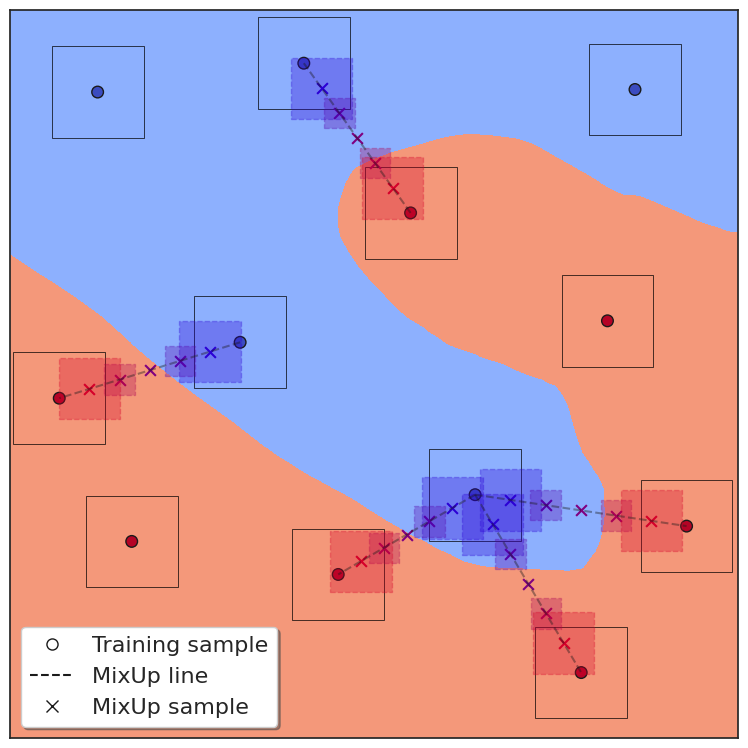

In [ ]:
plot_results_with_mixup(X, y, net, eps=0.07)